# Settings

1. change CODE_STRING = 'vasp@iceberg_direct' according to your environment.
1. change POTENTIAL_FAMILY = 'PBE.54' according to your environment.


In [1]:
"""
Call script to calculate the total energies for one volume of standard silicon.

This particular call script set up a standard calculation that execute a calculation for
the fcc silicon structure.
"""
# pylint: disable=too-many-arguments, invalid-name, import-outside-toplevel
from aiida.common.extendeddicts import AttributeDict
from aiida.orm import Code, Bool, Str
from aiida.plugins import DataFactory, WorkflowFactory
from aiida.engine import submit
from aiida import load_profile
load_profile()


def get_structure(label):
    from aiida.orm import QueryBuilder
    qb = QueryBuilder()
    qb.append(DataFactory('structure'), filters={'label': {'==': label}}, tag='structure')
    # Pick any structure with this label, here, just the first
    return qb.all()[0][0]


def main(code_string, incar, kmesh, structure, potential_family, potential_mapping, options):
    """Main method to setup the calculation."""

    # First, we need to fetch the AiiDA datatypes which will
    # house the inputs to our calculation
    dict_data = DataFactory('dict')
    kpoints_data = DataFactory('array.kpoints')

    # Then, we set the workchain you would like to call
    workchain = WorkflowFactory('vasp.verify')

    # And finally, we declare the options, settings and input containers
    settings = AttributeDict()
    inputs = AttributeDict()

    # organize settings
    
    # settings.parser_settings = {'add_dos': True, 'add_parameters': ['efermi']} # failed to get efermi
    settings.parser_settings = {'add_dos': True, 
                                'add_custom_node': {'quantities': ['efermi']} }
    
    # set inputs for the following WorkChain execution
    # set code
    inputs.code = Code.get_from_string(code_string)
    # set structure
    inputs.structure = structure
    # set k-points grid density
    kpoints = kpoints_data()
    kpoints.set_kpoints_mesh(kmesh)
    inputs.kpoints = kpoints
    # set parameters
    inputs.parameters = dict_data(dict=incar)
    # set potentials and their mapping
    inputs.potential_family = Str(potential_family)
    inputs.potential_mapping = dict_data(dict=potential_mapping)
    # set options
    inputs.options = dict_data(dict=options)
    # set settings
    inputs.settings = dict_data(dict=settings)
    # set workchain related inputs, in this case, give more explicit output to report
    inputs.verbose = Bool(True)
    # submit the requested workchain with the supplied inputs
    return submit(workchain, **inputs)


if __name__ == '__main__':
    # Code_string is chosen among the list given by 'verdi code list'
    CODE_STRING = 'vasp6@iceberg_direct'

    # INCAR equivalent
    # Set input parameters
    INCAR = {'incar': {'encut': 240, 'ismear': -5, 'lorbit': 11}}

    # KPOINTS equivalent
    # Set kpoint mesh
    KMESH = [9,9,9]

    # POTCAR equivalent
    # Potential_family is chosen among the list given by
    # 'verdi data vasp-potcar listfamilies'
    POTENTIAL_FAMILY = 'PBE.54'
    # The potential mapping selects which potential to use, here we use the standard
    # for silicon, this could for instance be {'Si': 'Si_GW'} to use the GW ready
    # potential instead
    POTENTIAL_MAPPING = {'Si': 'Si'}

    # jobfile equivalent
    # In options, we typically set scheduler options.
    # See https://aiida.readthedocs.io/projects/aiida-core/en/latest/scheduler/index.html
    # AttributeDict is just a special dictionary with the extra benefit that
    # you can set and get the key contents with mydict.mykey, instead of mydict['mykey']
    OPTIONS = AttributeDict()
    OPTIONS.account = ''
    OPTIONS.qos = ''
    OPTIONS.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 2}
    OPTIONS.queue_name = ''
    OPTIONS.max_wallclock_seconds = 3600
    OPTIONS.max_memory_kb = 1024000

    # POSCAR equivalent
    # Set the silicon structure
    STRUCTURE = get_structure('silicon_at_3_9')
    print("structure", STRUCTURE)

    workchain = main(CODE_STRING, INCAR, KMESH, STRUCTURE, POTENTIAL_FAMILY, POTENTIAL_MAPPING, OPTIONS)

structure uuid: a62174ce-cf41-429b-9b11-48cf9097c575 (pk: 5509)


In [2]:
workchain

<WorkChainNode: uuid: 53386391-8fdd-4bff-830e-d2137e4379f0 (pk: 5776) (aiida.workflows:vasp.verify)>

エラーが出た場合は
```sh
$ verdi process show $pk
$ verdi process report $pk
```
で詳細を調べる。


# DOS plot
まず、出力を見る。

In [3]:
!verdi process show $workchain.pk

Property     Value
-----------  ------------------------------------
type         VerifyWorkChain
state        Waiting
pk           5776
uuid         53386391-8fdd-4bff-830e-d2137e4379f0
label
description
ctime        2021-07-27 07:51:03.125769+00:00
mtime        2021-07-27 07:51:07.171094+00:00
computer     [4] iceberg_direct

Inputs              PK    Type
------------------  ----  -------------
verify
    max_iterations  5775  Int
clean_workdir       5774  Bool
code                5468  Code
kpoints             5766  KpointsData
max_iterations      5773  Int
options             5770  Dict
parameters          5767  Dict
potential_family    5768  Str
potential_mapping   5769  Dict
settings            5771  Dict
structure           5509  StructureData
verbose             5772  Bool

Called      PK  Type
--------  ----  -------------
CALL      5777  VaspWorkChain

Log messages
---------------------------------------------
There are 1 log messages for this calculation
Run 'verdi process 

In [9]:
import time
while not workchain.is_finished or not workchain.is_terminated:
    print("sleep 5 sec")
    time.sleep(5)
workchain.is_finished_ok

sleep 5 sec
sleep 5 sec
sleep 5 sec
sleep 5 sec
sleep 5 sec
sleep 5 sec
sleep 5 sec
sleep 5 sec


True

dosはArrayDataである。その要素を見る。

In [10]:
workchain.outputs.dos.attributes

{'array|pdos': [1, 301, 9], 'array|tdos': [301], 'array|energy': [301]}

ArrayDataの種類と、名前と、shapeがわかる。

ArrayDataを取得してDOSをplotする。

'done'

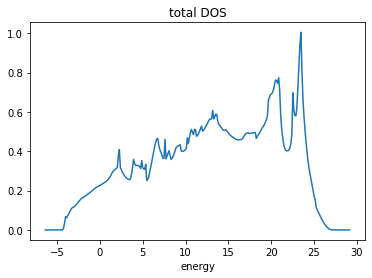

In [11]:
energy = workchain.outputs.dos.get_array("energy")
tdos = workchain.outputs.dos.get_array("tdos")

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(energy,tdos)
ax.set_xlabel("energy")
ax.set_title("total DOS")
"done"

/home/max/.virtualenvs/aiida/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


'done'

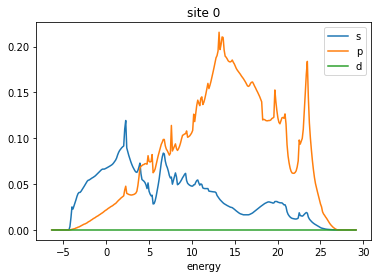

In [12]:
energy = workchain.outputs.dos.get_array("energy")
pdos = workchain.outputs.dos.get_array("pdos")

import numpy as np
import matplotlib.pyplot as plt
for i in range(pdos.shape[0]):
    fig, ax = plt.subplots()
    ax.plot(energy,pdos[0,:,0], label="s")
    ax.plot(energy,np.sum(pdos[0,:,1:4], axis=1), label="p")
    ax.plot(energy,np.sum(pdos[0,:,4:], axis=1), label="d")
    ax.legend()
    ax.set_xlabel("energy")
    ax.set_title("site %d" % i)
    fig.show()
"done"

In [ ]:
workchain.outputs.misc.attributes

# efermiが取れない。